# **Trabajo práctico: Procesamiento en la nube**

- Fabian Salazar
- Raul Echeverry
- Esteban Ordoñez

<br></br>
### **Introducción**

En el presente trabajo se aborda un análisis y detección de anomalías en un conjunto de datos utilizando la biblioteca Deequ, desarrollada por Amazon. Deequ es una herramienta poderosa para evaluar la calidad de los datos mediante la creación de métricas estadísticas y el uso de técnicas automatizadas para identificar irregularidades. Este análisis sigue una metodología estructurada que incluye las siguientes etapas:

1. **Selección del Dataset**:
Se ha seleccionado un conjunto de datos que contiene diferentes tipos de información (numérica, categórica, y posiblemente temporal), con el fin de maximizar la riqueza y diversidad del análisis. Una parte de este dataset será destinada a representar datos "nuevos", mientras que otra parte servirá como referencia histórica. Esto permitirá aplicar técnicas de detección de anomalías, evaluando la consistencia entre datos actuales y pasados.

2. **Aplicación de Deequ Profiling**:
En esta etapa, se utilizará Deequ para realizar un perfilado inicial del dataset. Este proceso permitirá obtener una visión global de la distribución de los datos, su integridad, la existencia de valores atípicos, y otras métricas relevantes. Estas métricas iniciales proporcionan la base para establecer criterios de calidad.

3. **Uso de Deequ Analyzer**:
Posteriormente, se aplicarán los análisis del módulo Analyzer de Deequ, que permite extraer métricas específicas del dataset. Estas métricas incluyen estadísticas descriptivas avanzadas, correlaciones y otras propiedades de los datos. Los resultados serán fundamentales para establecer reglas de calidad.

4. **Detección de Anomalías con Deequ**:
Finalmente, mediante el módulo de detección de anomalías de Deequ, se identificarán patrones inesperados en los datos nuevos en comparación con los históricos. Esta etapa tiene como objetivo detectar desviaciones significativas que podrían señalar problemas de calidad, errores en los datos o tendencias fuera de lo común.

A través de este enfoque, se busca demostrar cómo Deequ puede ser utilizado de manera eficiente para evaluar y garantizar la calidad de los datos, proporcionando un marco práctico y robusto para el análisis de grandes volúmenes de información.




#### **Preparación de entorno**

En esta sección se configura el entorno necesario para utilizar PyDeequ, se instala OpenJDK 8, ya que Spark requiere Java para ejecutarse; PySpark, que permite interactuar con Spark desde Python; y PyDeequ, que facilita la aplicación de métricas de calidad, análisis estadísticos y detección de anomalías en los datos, aprovechando el procesamiento distribuido de Spark. Esta configuración prepara el entorno para las siguientes fases del análisis descritas en este trabajo.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install pydeequ

In [4]:
# Se crea variable de entorno
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.10/dist-packages/pyspark"
os.environ["SPARK_VERSION"] = "3.2"

In [5]:
!pip install sagemaker-pyspark

#### **Importación de librerias**


In [6]:
import pydeequ
import sagemaker_pyspark
from pyspark.sql import SparkSession, Row
from pydeequ.profiles import *
from pyspark.sql.types import *
from pyspark.sql.functions import col, when, expr
from pydeequ.analyzers import *
from pydeequ.analyzers import AnalysisRunner, Minimum, Maximum, Mean, Size
from pydeequ.repository import *
from pydeequ.verification import *
from pydeequ.anomaly_detection import *

import matplotlib.pyplot as plt
import math
import pandas as pd

# **1. Dataset**
El dataset seleccionado es adecuado para este análisis, ya que incluye una diversidad de tipos de variables, lo que permite aplicar técnicas avanzadas de calidad de datos y detección de anomalías. A continuación, se describe cada columna con su tipo de variable y su relevancia:

- ***ID:*** Identificador único de tipo categórica nominal que distingue a cada cliente. Es crucial para mantener la integridad de los registros, pero no interviene en el análisis predictivo directamente.
- ***Sector_Actividad:*** Variable categórica nominal que indica el sector económico al que pertenece el cliente. Es útil para analizar tendencias en sectores específicos.
- ***Sexo:*** Variable categórica nominal que representa el género del cliente (Hombre o Mujer), relevante para estudios demográficos.
- ***Estado_Civil:*** Variable categórica nominal que clasifica a los clientes según su estado civil (e.g., Soltero/a, Casado/a, Unión Libre). Permite analizar patrones de mora según el estado civil.
- ***Tipo_Vivienda:*** Variable categórica nominal que describe el tipo de vivienda del cliente (Arrendada, Familiar, etc.). Es útil para identificar correlaciones con la capacidad de pago.
- ***Tipo_cliente:*** Variable categórica nominal que clasifica a los clientes según su relación con el banco (e.g., Nuevo). Esto ayuda a entender el comportamiento de diferentes tipos de clientes.
- ***Edad:*** Variable numérica continua que representa la edad del cliente en años. Permite analizar cómo la edad influye en el riesgo de mora.
- ***Personas_a_Cargo:*** Variable numérica discreta que indica el número de personas dependientes del cliente. Es importante para evaluar la carga económica.
- ***Tasa:*** Variable numérica continua que corresponde a la tasa de interés asociada al crédito. Puede influir directamente en la capacidad del cliente para pagar.
- ***Monto:*** Variable numérica continua que describe el valor del crédito solicitado. Es clave para analizar la relación entre el tamaño del crédito y la probabilidad de incumplimiento.
- ***Plazo_Meses:*** Variable numérica discreta que especifica el plazo del crédito en meses. Permite evaluar el impacto de los términos del crédito en la probabilidad de mora.

Este dataset es idóneo para el análisis, ya que combina variables numéricas y categóricas, lo que enriquece las posibilidades de evaluación y detección de anomalías. Además, las variables seleccionadas tienen una relación lógica con la problemática de estudio: el riesgo de mora.

El dataset seleccionado contiene un total de ***8.000 registros***, cada uno correspondiente a un cliente de una entidad bancaria. Estos registros serán divididos en dos subconjuntos de igual tamaño: ***4.000 registros se utilizarán como datos históricos, mientras que los 4.000 registros restantes representarán datos "nuevos"***. Esta división es esencial para la detección de anomalías, ya que permite comparar los patrones y métricas estadísticas de los datos nuevos frente a los históricos, identificando irregularidades o comportamientos atípicos en las características de los clientes.

La riqueza del dataset y su volumen lo hacen ideal para aplicar técnicas de análisis avanzado, asegurando la robustez de las métricas de calidad y las conclusiones derivadas del estudio.

In [7]:
# Cargar el archivo Excel usando pandas
url = "https://github.com/leoe21/Data_Science/raw/refs/heads/main/Procesamiento_Nube_Anomalias_con_Deequ/Base_Banco_Nube.xlsx"
dataset = pd.read_excel(url, sheet_name="Historica")
dataset

,ID,Sector_Actividad,Sexo,Estado_Civil,Tipo_Vivienda,Tipo_cliente,Edad,Personas_a_Cargo,Tasa,Monto,Plazo_Meses
0,1,COMERCIO,Mujer,Unión Libre,Arrendada,Nuevo,24,0,52.89,2400000.0,12
1,2,AGRICULTURA,Mujer,Casado/a,Arrendada,Nuevo,34,1,55.00,5582000.0,23
2,3,COMERCIO,Mujer,Soltero/a,Arrendada,Nuevo,23,0,52.39,2300000.0,20
3,4,ARTESANÍAS,Hombre,Soltero/a,Familiar,Nuevo,22,0,55.20,1774000.0,16
4,5,SERVICIOS,Mujer,Soltero/a,Familiar,Nuevo,21,0,63.00,2000000.0,14
...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,PECUARIO,Mujer,Soltero/a,Propia sin Deuda,Nuevo,36,0,48.50,5914000.0,30
3996,3997,SERVICIOS,Hombre,Soltero/a,Familiar,Nuevo,25,0,49.04,2120000.0,6
3997,3998,COMERCIO,Hombre,Soltero/a,Arrendada,Nuevo,20,0,46.80,8400000.0,24
3998,3999,AGRICULTURA,Hombre,Unión Libre,Arrendada,Nuevo,20,0,52.39,5480000.0,28


In [8]:
# Revisar tipos de datos
print(dataset.dtypes)


ID                    int64
Sector_Actividad     object
Sexo                 object
Estado_Civil         object
Tipo_Vivienda        object
Tipo_cliente         object
Edad                  int64
Personas_a_Cargo      int64
Tasa                float64
Monto               float64
Plazo_Meses           int64
dtype: object


In [9]:
# Convertir el DataFrame de pandas a una lista de diccionarios
data_list = dataset.to_dict(orient='records')

### Crear esquema para pyspark

In [10]:
# Definir el esquema
schema = StructType([
    StructField("ID", IntegerType(), True),                     # Identificador único (entero)
    StructField("Sector_Actividad", StringType(), True),        # Sector de actividad (texto)
    StructField("Sexo", StringType(), True),                    # Sexo (texto: Mujer/Hombre)
    StructField("Estado_Civil", StringType(), True),            # Estado civil (texto: Unión Libre, Casado/a, etc.)
    StructField("Tipo_Vivienda", StringType(), True),           # Tipo de vivienda (texto: Arrendada, Familiar, etc.)
    StructField("Tipo_cliente", StringType(), True),            # Tipo de cliente (texto: Nuevo, etc.)
    StructField("Edad", IntegerType(), True),                   # Edad (entero)
    StructField("Personas_a_Cargo", IntegerType(), True),       # Personas a cargo (entero)
    StructField("Tasa", FloatType(), True),                     # Tasa de interés (decimal con coma o punto)
    StructField("Monto", FloatType(), True),                    # Monto (decimal)
    StructField("Plazo_Meses", IntegerType(), True)             # Plazo en meses (entero)
])

# **2. Profiling**

In [11]:
classpath = ":".join(sagemaker_pyspark.classpath_jars()) # aws-specific jars

spark = (SparkSession
    .builder
    .config("spark.driver.extraClassPath", classpath)
    .config("spark.jars.packages", pydeequ.deequ_maven_coord)
    .config("spark.jars.excludes", pydeequ.f2j_maven_coord)
    .getOrCreate())

In [12]:
# Crear el DataFrame de PySpark desde la lista de datos y el esquema
spark_df = spark.createDataFrame(data_list, schema)

In [13]:
# Mostrar las primeras filas del DataFrame de PySpark
spark_df.show(5)

+---+----------------+------+------------+-------------+------------+----+----------------+-----+---------+-----------+
| ID|Sector_Actividad|  Sexo|Estado_Civil|Tipo_Vivienda|Tipo_cliente|Edad|Personas_a_Cargo| Tasa|    Monto|Plazo_Meses|
+---+----------------+------+------------+-------------+------------+----+----------------+-----+---------+-----------+
|  1|        COMERCIO| Mujer| Unión Libre|    Arrendada|       Nuevo|  24|               0|52.89|2400000.0|         12|
|  2|     AGRICULTURA| Mujer|    Casado/a|    Arrendada|       Nuevo|  34|               1| 55.0|5582000.0|         23|
|  3|        COMERCIO| Mujer|   Soltero/a|    Arrendada|       Nuevo|  23|               0|52.39|2300000.0|         20|
|  4|      ARTESANÍAS|Hombre|   Soltero/a|     Familiar|       Nuevo|  22|               0| 55.2|1774000.0|         16|
|  5|       SERVICIOS| Mujer|   Soltero/a|     Familiar|       Nuevo|  21|               0| 63.0|2000000.0|         14|
+---+----------------+------+-----------

### Revisando la completitud y tipos de datos del dataset

In [14]:
# Ejecutar el perfilador de columnas
result = ColumnProfilerRunner(spark) \
    .onData(spark_df) \
    .run()

# Mostrar estadísticas de todas las columnas excepto 'ID'
for col, profile in result.profiles.items():
    if col != "ID":  # Excluir la columna 'ID'
        print(f'Columna: \'{col}\'')
        print('\t', f'Completitud: {profile.completeness}')  # Proporción de valores no nulos
        print('\t', f'Número aproximado de valores únicos: {profile.approximateNumDistinctValues}')
        print('\t', f'Tipo de dato: {profile.dataType}')
        print()  # Línea en blanco para separar columnas


Columna: 'Sector_Actividad'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 13
	 Tipo de dato: String

Columna: 'Edad'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 37
	 Tipo de dato: Integral

Columna: 'Tipo_Vivienda'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 5
	 Tipo de dato: String

Columna: 'Monto'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 1543
	 Tipo de dato: Fractional

Columna: 'Personas_a_Cargo'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 6
	 Tipo de dato: Integral

Columna: 'Sexo'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 2
	 Tipo de dato: String

Columna: 'Tasa'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 104
	 Tipo de dato: Fractional

Columna: 'Estado_Civil'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 5
	 Tipo de dato: String

Columna: 'Tipo_cliente'
	 Completitud: 1.0
	 Número aproximado de valores únicos: 2
	 Tipo de dato: String

Columna: 'Plazo_Meses'
	 Comple

El dataset tien data completa, la mayor cantidad de valores únicos se encuentran en la variable "monto" del crédito y la de menores valores únicos es la de "Tipo_cliente"

### Estadísticas básicas de las columnas tipo numéricas

In [15]:
# Crear un DataFrame temporal con columnas numéricas para graficar
numeric_columns = {}

# Iterar sobre todas las columnas con perfiles generados por PyDeequ
for col, profile in result.profiles.items():
    # Verificar si el tipo de dato es numérico y no es la columna ID
    if col != "ID" and (profile.dataType == "Integral" or profile.dataType == "Fractional"):
        print(f'Estadísticas \'{col}\':')
        print('\t', f"Mínimo: {profile.minimum}")
        print('\t', f"Máximo: {profile.maximum}")
        print('\t', f"Media: {profile.mean}")
        print('\t', f"Desviación estandar: {profile.stdDev}")
        print()  # Línea en blanco para separar columnas
        # Agregar los valores de la columna al diccionario
        numeric_columns[col] = spark_df.select(col).rdd.flatMap(lambda x: x).collect()


Estadísticas 'Edad':
	 Mínimo: 18.0
	 Máximo: 65.0
	 Media: 23.87525
	 Desviación estandar: 4.7894871789681215

Estadísticas 'Monto':
	 Mínimo: 500000.0
	 Máximo: 60000000.0
	 Media: 3489418.47978125
	 Desviación estandar: 3217173.757889141

Estadísticas 'Personas_a_Cargo':
	 Mínimo: 0.0
	 Máximo: 5.0
	 Media: 0.49025
	 Desviación estandar: 0.7732431296170694

Estadísticas 'Tasa':
	 Mínimo: 20.0
	 Máximo: 63.0
	 Media: 51.46771736431122
	 Desviación estandar: 6.127356578577153

Estadísticas 'Plazo_Meses':
	 Mínimo: 6.0
	 Máximo: 48.0
	 Media: 16.63375
	 Desviación estandar: 6.544739180250047



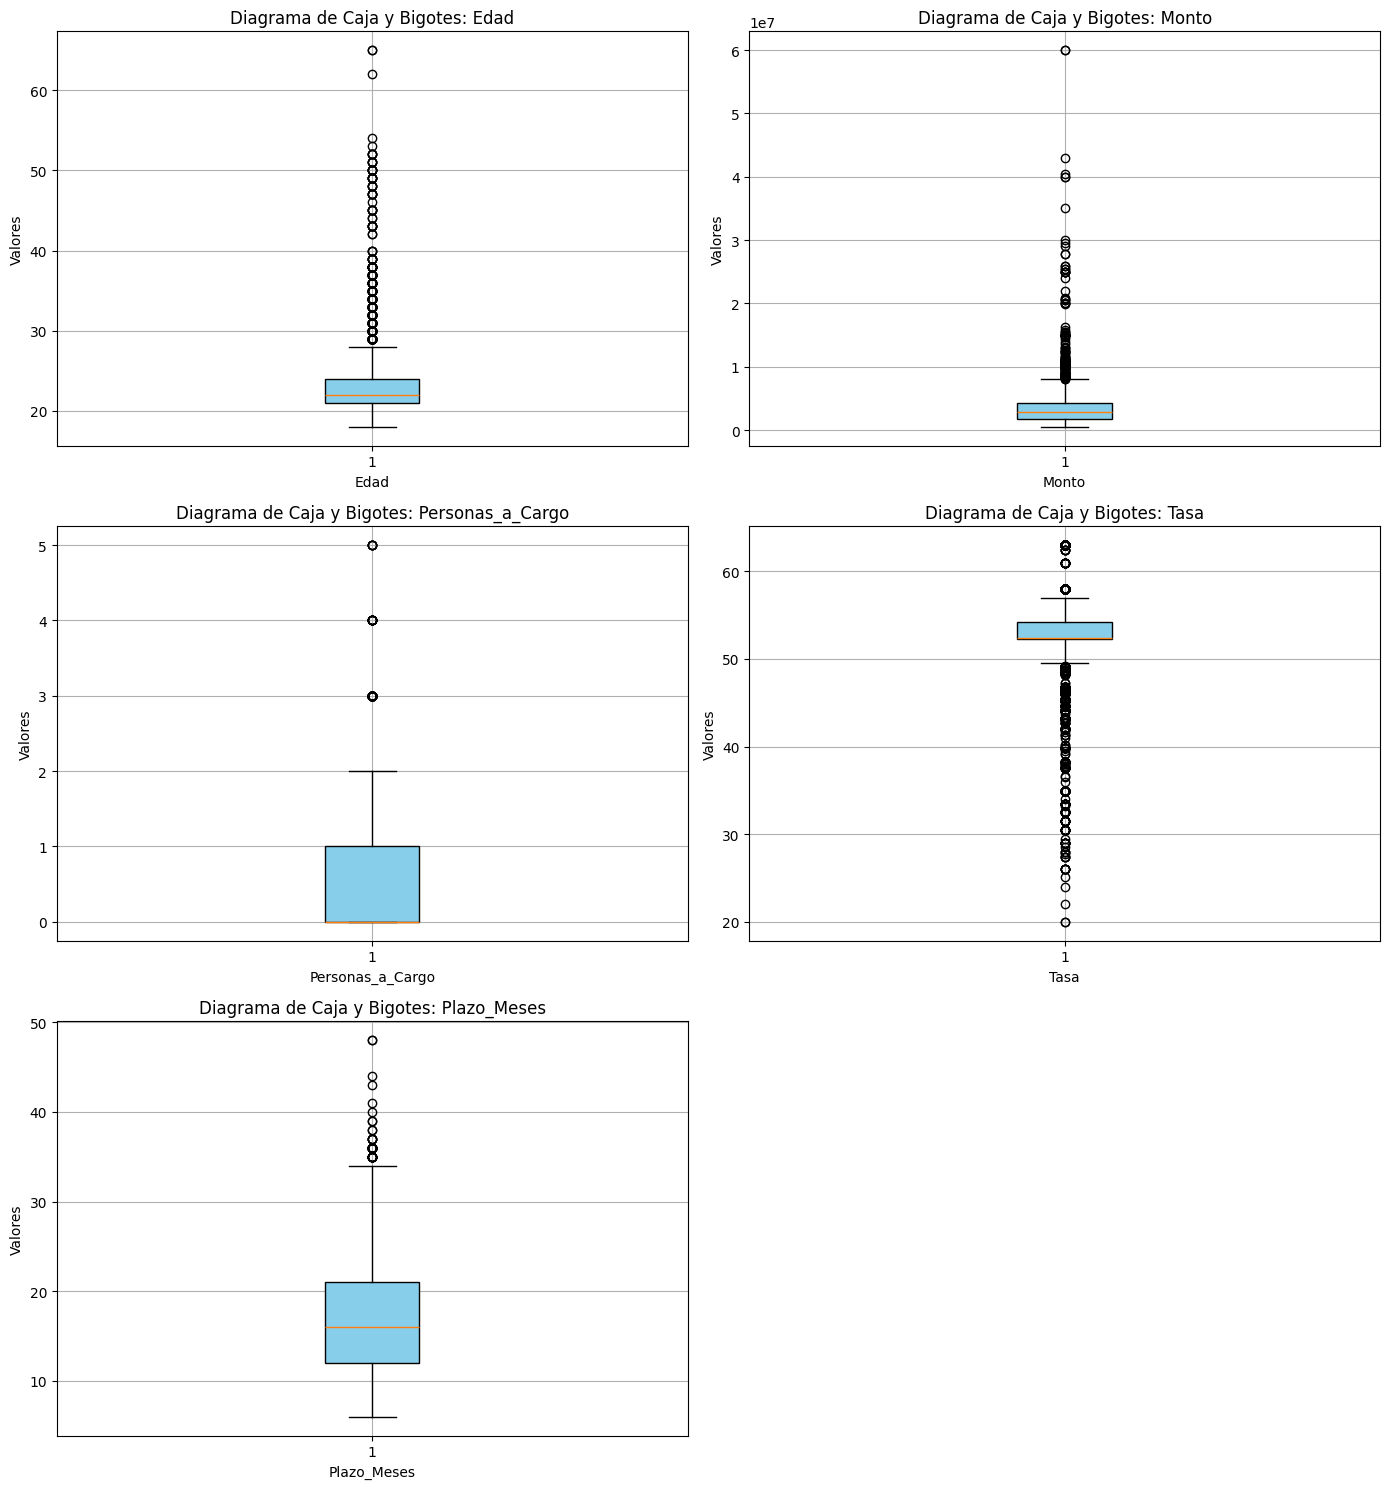

In [16]:
# Convertir a DataFrame de pandas para graficar
numeric_df = pd.DataFrame(numeric_columns)

# Determinar el número total de columnas y filas necesarias
columns_per_row = 2
num_columns = len(numeric_df.columns)
num_rows = math.ceil(num_columns / columns_per_row)

# Crear la figura y los ejes
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(14, 5 * num_rows))
axes = axes.flatten()  # Aplanar para iterar fácilmente si es necesario

# Graficar cada columna numérica
for idx, column in enumerate(numeric_df.columns):
    axes[idx].boxplot(numeric_df[column], vert=True, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    axes[idx].set_title(f"Diagrama de Caja y Bigotes: {column}")
    axes[idx].set_ylabel("Valores")
    axes[idx].set_xlabel(column)
    axes[idx].grid(True)

# Ocultar ejes no usados (si hay un número impar de columnas)
for idx in range(num_columns, len(axes)):
    fig.delaxes(axes[idx])

# Ajustar diseño y mostrar la gráfica
plt.tight_layout()
plt.show()



*Conclusiones:*
1. La población objetivo parece ser principalmente joven. Los valores atípicos podrían corresponder a clientes mayores con características inusuales para este perfil.

2. La mayoría de los clientes solicitan montos pequeños o moderados, pero hay un pequeño grupo que representa préstamos significativamente altos, lo que podría ser un segmento distinto (como empresas o clientes preferenciales).

3. La base de clientes incluye personas independientes o con pocas responsabilidades familiares, pero hay excepciones de clientes con muchas personas dependientes.

4. La mayoría de los clientes reciben tasas estándar, pero las tasas fuera de este rango podrían reflejar condiciones excepcionales (descuentos especiales o riesgos elevados).

5. Los préstamos a corto y mediano plazo parecen ser los más comunes, mientras que los plazos extendidos son excepcionales y podrían ser casos especiales o asociados con montos más altos.

### Estadísticas básicas de las columnas tipo string

In [17]:
# Identificar las columnas de tipo string en el esquema
string_columns = [field.name for field in spark_df.schema.fields if isinstance(field.dataType, StringType)]

# Iterar sobre las columnas categóricas y generar gráficos
for col in string_columns:
    # Obtener el perfil de la columna
    column_profile = result.profiles[col]

    # Crear listas para valores únicos y sus frecuencias
    values = [unique_entry.value for unique_entry in column_profile.histogram]
    counts = [unique_entry.count for unique_entry in column_profile.histogram]

    # Imprimir la distribución en texto
    print()
    print(f"Valores distribuidos en la columna '{col}':")
    for value, count in zip(values, counts):
        print(f" - {value}: ocurre {count} veces")



Valores distribuidos en la columna 'Sector_Actividad':
 - SERVICIOS: ocurre 885 veces
 - ACTIVIDADES DEPENDIENTES: ocurre 444 veces
 - PESCA: ocurre 4 veces
 - AGRICULTURA: ocurre 1172 veces
 - ARTESANÍAS: ocurre 18 veces
 - CUEROS: ocurre 7 veces
 - MADERA: ocurre 17 veces
 - PECUARIO: ocurre 484 veces
 - INDUSTRIA: ocurre 76 veces
 - AGROINDUSTRIA: ocurre 72 veces
 - COMERCIO: ocurre 781 veces
 - CONFECCIONES: ocurre 35 veces
 - ALFARERÍA: ocurre 5 veces

Valores distribuidos en la columna 'Sexo':
 - Mujer: ocurre 1859 veces
 - Hombre: ocurre 2141 veces

Valores distribuidos en la columna 'Estado_Civil':
 - Soltero/a: ocurre 2570 veces
 - Viudo/a: ocurre 8 veces
 - Casado/a: ocurre 155 veces
 - Unión Libre: ocurre 1208 veces
 - Separado/a: ocurre 59 veces

Valores distribuidos en la columna 'Tipo_Vivienda':
 - Propia sin Deuda: ocurre 571 veces
 - Arrendada: ocurre 1000 veces
 - Familiar: ocurre 2192 veces
 - Anticresis: ocurre 2 veces
 - Propia con Deuda: ocurre 235 veces

Valores 

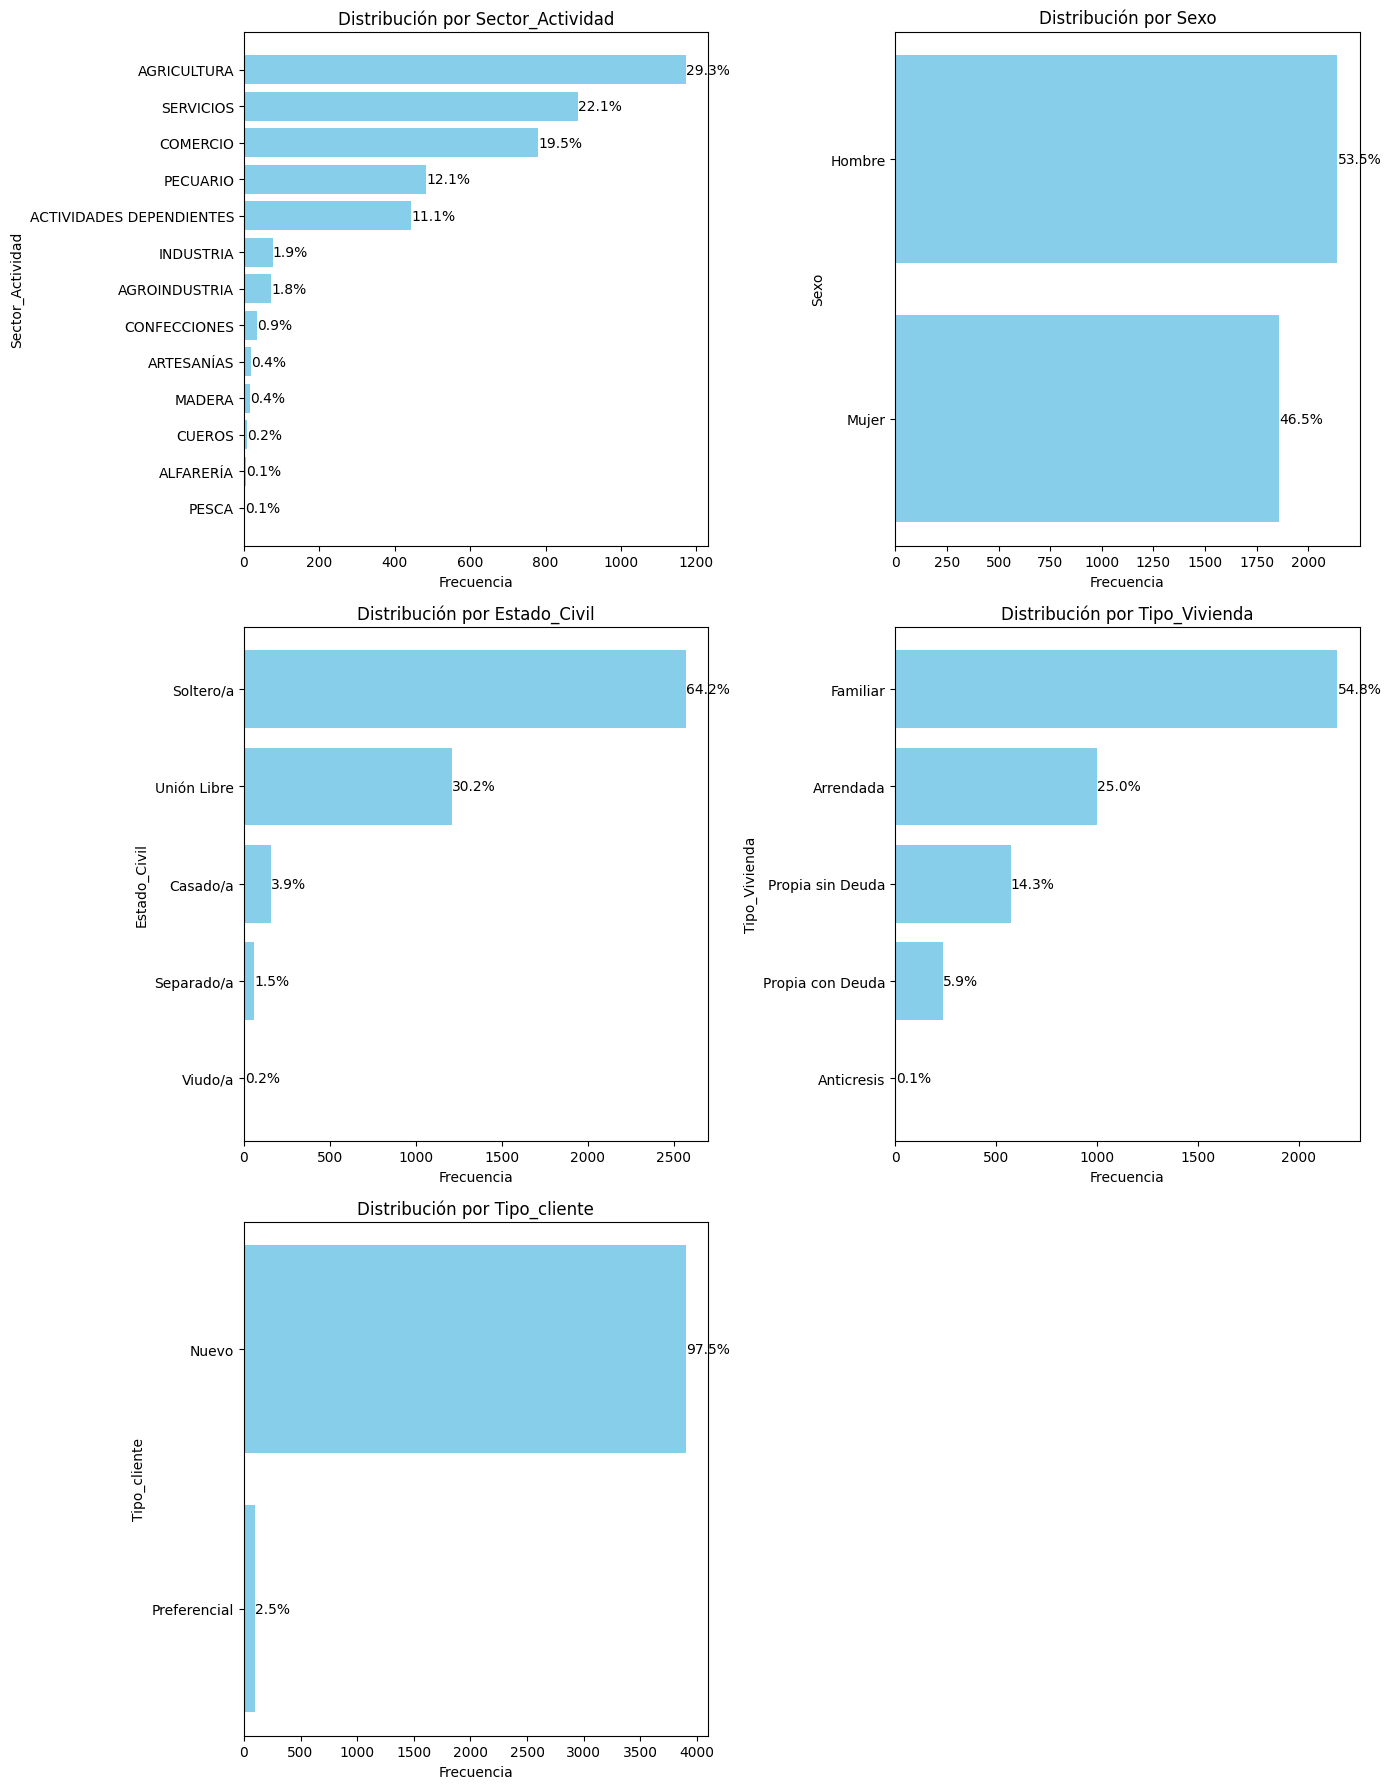

In [18]:
# Configuración para gráficos en filas de 2 columnas
num_cols = 2
num_rows = (len(string_columns) + 1) // num_cols  # Calcular el número de filas necesarias

# Crear el canvas para todos los gráficos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 6 * num_rows))
axes = axes.flatten()  # Aplanar para iterar fácilmente si hay varias filas

# Iterar sobre las columnas categóricas y generar gráficos
for idx, col in enumerate(string_columns):
    # Obtener el perfil de la columna
    column_profile = result.profiles[col]

    # Crear listas para valores únicos y sus frecuencias
    values = [unique_entry.value for unique_entry in column_profile.histogram]
    counts = [unique_entry.count for unique_entry in column_profile.histogram]
    total = sum(counts)

    # Calcular porcentajes
    percentages = [(count / total) * 100 for count in counts]

    # Ordenar por porcentaje de mayor a menor
    sorted_data = sorted(zip(percentages, counts, values), reverse=True, key=lambda x: x[0])
    percentages, counts, values = zip(*sorted_data)

    # Generar el gráfico de barras horizontal
    ax = axes[idx]
    bars = ax.barh(values, counts, color='skyblue')

    # Agregar etiquetas con porcentajes en las barras
    for bar, pct in zip(bars, percentages):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                f'{pct:.1f}%', va='center', fontsize=10)

    # Configuración del gráfico
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel(col)
    ax.set_title(f'Distribución por {col}')
    ax.invert_yaxis()  # Invertir eje Y para mejor visualización

# Ocultar ejes vacíos si no hay suficientes columnas
for idx in range(len(string_columns), len(axes)):
    fig.delaxes(axes[idx])

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()


*Conclusiones:*

1. Las actividades económicas están dominadas por sectores tradicionales como agricultura, servicios y comercio, lo cual refleja un enfoque económico basado en actividades básicas.

2. Existe una participación equitativa de géneros con una ligera inclinación hacia hombres.

3. La población de clientes parece estar dominada por personas jóvenes o no casadas, lo que podría ser indicativo del mercado objetivo.

4. La mayoría de los clientes parecen depender de viviendas familiares o arriendos, reflejando un nivel de estabilidad económica moderado.

5. La entidad parece estar enfocada en la adquisición de nuevos clientes, mientras que la fidelización de clientes preferenciales es mínima.

# **3. Analyzers**

In [19]:
# Crear la sesión de Spark
spark = (SparkSession.builder
    .appName("PyDeequ Analyzers")
    .config("spark.driver.extraClassPath", ":".join(["path/to/pydeequ", "path/to/other/jars"]))  # Ajusta el classpath según tu entorno
    .getOrCreate())

In [20]:
# Excluir la columna 'ID'
columns_to_analyze = [col for col in spark_df.columns if col != "ID"]

# Configurar el análisis dinámico para las columnas
analysis = AnalysisRunner(spark).onData(spark_df)

# Agregar analizadores dinámicamente
for column in columns_to_analyze:
    analysis = analysis.addAnalyzer(Completeness(column))  # Completitud
    if spark_df.schema[column].dataType in (IntegerType(), FloatType()):  # Solo para columnas numéricas
        analysis = analysis.addAnalyzer(Mean(column))  # Media
        analysis = analysis.addAnalyzer(ApproxCountDistinct(column))  # Conteo único aproximado

# Ejecutar el análisis
analysisResult = analysis.run()

# Convertir los resultados a un DataFrame de PySpark
analysisResult_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult)

# Mostrar los resultados
analysisResult_df.show()



+------+----------------+-------------------+-----------------+
|entity|        instance|               name|            value|
+------+----------------+-------------------+-----------------+
|Column|           Monto|       Completeness|              1.0|
|Column|            Edad|       Completeness|              1.0|
|Column|    Tipo_cliente|       Completeness|              1.0|
|Column|   Tipo_Vivienda|       Completeness|              1.0|
|Column|            Sexo|       Completeness|              1.0|
|Column|            Tasa|               Mean|51.46771736431122|
|Column|            Tasa|ApproxCountDistinct|            104.0|
|Column|            Tasa|       Completeness|              1.0|
|Column|            Edad|               Mean|         23.87525|
|Column|            Edad|ApproxCountDistinct|             37.0|
|Column|     Plazo_Meses|               Mean|         16.63375|
|Column|     Plazo_Meses|ApproxCountDistinct|             39.0|
|Column|    Estado_Civil|       Complete

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


In [21]:
# Convertir los resultados a un DataFrame de pandas
analysisResult_pandas_df = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult, pandas=True)

# Mostrar los resultados en pandas
analysisResult_pandas_df


,entity,instance,name,value
0,Column,Monto,Completeness,1.000000e+00
1,Column,Edad,Completeness,1.000000e+00
2,Column,Tipo_cliente,Completeness,1.000000e+00
3,Column,Tipo_Vivienda,Completeness,1.000000e+00
4,Column,Sexo,Completeness,1.000000e+00
5,Column,Tasa,Mean,5.146772e+01
6,Column,Tasa,ApproxCountDistinct,1.040000e+02
7,Column,Tasa,Completeness,1.000000e+00
8,Column,Edad,Mean,2.387525e+01
9,Column,Edad,ApproxCountDistinct,3.700000e+01


*Conclusiones:*
1. Calidad de los Datos: No hay valores nulos, lo que refleja un dataset limpio y listo para el análisis.

2. Demografía: Los clientes son principalmente jóvenes (edad promedio de 23.88 años) y tienen pocas personas a cargo (promedio de 0.49).

3. Préstamos: Los préstamos suelen ser de montos moderados (3,489,418 pesos en promedio), con plazos a mediano plazo (16.6 meses).
Las tasas de interés están en rangos estándar, con un promedio de 51.47%.

4. Variabilidad: Las columnas numéricas como Monto, Tasa, y Plazo_Meses tienen alta variabilidad, lo que indica que las condiciones de los préstamos son diversas y personalizadas.

# **4. Anomaly Detention**

In [22]:
# Crear un repositorio en memoria para almacenar métricas
metricsRepository = InMemoryMetricsRepository(spark)


### Configurar el Dataset Histórico

Debemos simular los datos de ayer (históricos) desde tu dataset para la detección de anomalías. Aquí seleccionamos una muestra de tu dataset para representar los datos históricos:


In [23]:
yesterdaysDataset=spark_df
yesterdaysDataset.show()

+---+--------------------+------+------------+----------------+------------+----+----------------+-----+---------+-----------+
| ID|    Sector_Actividad|  Sexo|Estado_Civil|   Tipo_Vivienda|Tipo_cliente|Edad|Personas_a_Cargo| Tasa|    Monto|Plazo_Meses|
+---+--------------------+------+------------+----------------+------------+----+----------------+-----+---------+-----------+
|  1|            COMERCIO| Mujer| Unión Libre|       Arrendada|       Nuevo|  24|               0|52.89|2400000.0|         12|
|  2|         AGRICULTURA| Mujer|    Casado/a|       Arrendada|       Nuevo|  34|               1| 55.0|5582000.0|         23|
|  3|            COMERCIO| Mujer|   Soltero/a|       Arrendada|       Nuevo|  23|               0|52.39|2300000.0|         20|
|  4|          ARTESANÍAS|Hombre|   Soltero/a|        Familiar|       Nuevo|  22|               0| 55.2|1774000.0|         16|
|  5|           SERVICIOS| Mujer|   Soltero/a|        Familiar|       Nuevo|  21|               0| 63.0|2000000

### Configurar el Dataset Actual

In [24]:
dataset_today = pd.read_excel(url, sheet_name="Actual")
dataset_today

data_list_today = dataset_today.to_dict(orient='records')

# Crear el DataFrame de PySpark desde la lista de datos y el esquema
todaysDataset = spark.createDataFrame(data_list_today, schema)

# Mostrar las primeras filas del DataFrame de PySpark
todaysDataset.show()

+----+--------------------+------+------------+----------------+------------+----+----------------+-----+---------+-----------+
|  ID|    Sector_Actividad|  Sexo|Estado_Civil|   Tipo_Vivienda|Tipo_cliente|Edad|Personas_a_Cargo| Tasa|    Monto|Plazo_Meses|
+----+--------------------+------+------------+----------------+------------+----+----------------+-----+---------+-----------+
|4001|            PECUARIO| Mujer|   Soltero/a|        Familiar|       Nuevo|  25|               0|52.39|2196800.0|         12|
|4002|            COMERCIO|Hombre|   Soltero/a|       Arrendada|       Nuevo|  20|               0|49.04|1160000.0|         10|
|4003|         AGRICULTURA| Mujer|   Soltero/a|       Arrendada|       Nuevo|  20|               0|49.04|1164000.0|          9|
|4004|            PECUARIO| Mujer|   Soltero/a|        Familiar|       Nuevo|  20|               0|52.39|3256500.0|         15|
|4005|ACTIVIDADES DEPEN...| Mujer|   Soltero/a|       Arrendada|       Nuevo|  20|               0| 39.8

### Cálculo de métricas y detección de anomalias

In [27]:
#from pydeequ.analyzers import AnalysisRunner, Minimum, Maximum, Mean, Size
from pyspark.sql.functions import col, when, expr

# 1. Calcular métricas del dataset histórico
analysisResult_historical = AnalysisRunner(spark).onData(yesterdaysDataset) \
    .addAnalyzer(Size()) \
    .addAnalyzer(Minimum("Edad")) \
    .addAnalyzer(Maximum("Edad")) \
    .addAnalyzer(Mean("Personas_a_Cargo")) \
    .addAnalyzer(Mean("Monto")) \
    .addAnalyzer(Mean("Tasa")) \
    .addAnalyzer(Minimum("Tasa")) \
    .addAnalyzer(Maximum("Tasa")) \
    .addAnalyzer(Mean("Plazo_Meses")) \
    .addAnalyzer(Minimum("Plazo_Meses")) \
    .addAnalyzer(Maximum("Plazo_Meses")) \
    .run()

historicalMetrics = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult_historical) \
    .withColumnRenamed("value", "historical_value")

# 2. Calcular métricas del dataset actual
analysisResult_current = AnalysisRunner(spark).onData(todaysDataset) \
    .addAnalyzer(Size()) \
    .addAnalyzer(Minimum("Edad")) \
    .addAnalyzer(Maximum("Edad")) \
    .addAnalyzer(Mean("Monto")) \
    .addAnalyzer(Mean("Personas_a_Cargo")) \
    .addAnalyzer(Mean("Tasa")) \
    .addAnalyzer(Minimum("Tasa")) \
    .addAnalyzer(Maximum("Tasa")) \
    .addAnalyzer(Mean("Plazo_Meses")) \
    .addAnalyzer(Minimum("Plazo_Meses")) \
    .addAnalyzer(Maximum("Plazo_Meses")) \
    .run()

currentMetrics = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult_current) \
    .withColumnRenamed("value", "current_value")

# 3. Unir métricas históricas y actuales
comparison = historicalMetrics.join(
    currentMetrics,
    on=["entity", "instance", "name"],
    how="inner"
).select(
    col("entity"),
    col("instance"),
    col("name"),
    col("historical_value"),
    col("current_value")
)

# 4. Calcular cambio relativo y anomalías
comparison = comparison.withColumn(
    "relative_change",
    when(col("historical_value") != 0, (col("current_value") - col("historical_value")) / col("historical_value"))
    .otherwise(None)
).withColumn(
    "is_anomaly",
    when((col("name") == "Mean") & ((col("relative_change") > 0.03) | (col("relative_change") < -0.03)), True)
    .when((col("name").isin("Minimum", "Maximum")) & ((col("relative_change") > 0.2) | (col("relative_change") < -0.2)), True)
    .otherwise(False)
)

# 5. Mostrar anomalías detectadas
comparison.filter("is_anomaly = True").show()


/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+------+----------------+-------+----------------+----------------+--------------------+----------+
|entity|        instance|   name|historical_value|   current_value|     relative_change|is_anomaly|
+------+----------------+-------+----------------+----------------+--------------------+----------+
|Column|            Edad|Maximum|            65.0|            79.0|  0.2153846153846154|      true|
|Column|            Tasa|Minimum|            20.0|            14.0|                -0.3|      true|
|Column|           Monto|   Mean|3489418.47978125|3654813.96628125|0.047399154746944734|      true|
|Column|     Plazo_Meses|Minimum|             6.0|             0.0|                -1.0|      true|
|Column|Personas_a_Cargo|   Mean|         0.49025|         0.53675|  0.0948495665476796|      true|
+------+----------------+-------+----------------+----------------+--------------------+----------+



### Tratamiento de anomalias

### *Edad*
*Anomalía Detectada:*
El valor máximo de la edad en el dataset actual es 79 años, excediendo el límite de 65 años establecido por el negocio.

*Causa Potencial:*
Error en los datos o inclusión accidental de registros que no cumplen con las políticas de crédito.

*Acción Recomendable:*
Filtrar los datos y corregir cualquier registro con edades mayores a 65 años. Establecer una validación en el sistema para prevenir registros futuros con valores fuera de rango.

In [28]:
todaysDataset = todaysDataset.withColumn(
    "Edad",
    expr("CASE WHEN Edad > 65 THEN 65 ELSE Edad END")
)


### *Tasa*
*Anomalía Detectada:*
El valor mínimo de la tasa en el dataset actual es 14.0%, lo cual no cumple con el límite inferior de 20.0%.

*Causa Potencial:*
Error en los datos o inclusión de tasas promocionales no autorizadas.

*Acción Recomendable:*
Corregir cualquier registro con tasas menores a 20%, estableciendo la tasa mínima permitida en 20.0%.
Validar en el sistema que no se registren tasas menores a este límite.

In [29]:
todaysDataset = todaysDataset.withColumn(
    "Tasa",
    expr("CASE WHEN Tasa < 20 THEN 20 ELSE Tasa END")
)


### *Monto*
*Anomalía Detectada:*
Hay registros con un monto de 0, lo cual no es válido dado que el monto mínimo es 500,000.

*Causa Potencial:*
Error en los datos al capturar montos nulos o incorrectos.

*Acción Recomendable:*
Corregir cualquier registro con montos menores a 500,000 asignando el monto mínimo permitido. Implementar validaciones en el sistema para prevenir futuros errores.

In [30]:
todaysDataset = todaysDataset.withColumn(
    "Monto",
    expr("CASE WHEN Monto < 500000 THEN 500000 ELSE Monto END")
)


### *Plazo en Meses*
*Anomalía Detectada:*
Hay registros con un plazo de 0 meses, lo cual no tiene sentido para un crédito.

*Causa Potencial:*
Error en los datos o registros no validados adecuadamente.

*Acción Recomendable:*
Corregir los registros con plazo menor a 6 meses asignando el valor mínimo permitido. Implementar validaciones para evitar futuros errores.

In [31]:
todaysDataset = todaysDataset.withColumn(
    "Plazo_Meses",
    expr("CASE WHEN Plazo_Meses < 6 THEN 6 ELSE Plazo_Meses END")
)


### *Personas a Cargo*
*Anomalía Detectada:*
Hay registros donde el número de personas a cargo llega hasta 12, excediendo el límite de 6.

*Causa Potencial:*
Error en la captura de datos o casos excepcionales no contemplados por las políticas.

*Acción Recomendable:*
Corregir los registros con valores superiores a 6 asignando el valor máximo permitido. Establecer validaciones para prevenir futuros errores.

In [32]:
todaysDataset = todaysDataset.withColumn(
    "Personas_a_Cargo",
    expr("CASE WHEN Personas_a_Cargo > 6 THEN 6 ELSE Personas_a_Cargo END")
)


In [33]:
# Calcular métricas del dataset actual con las modificaciones
analysisResult_current = AnalysisRunner(spark).onData(todaysDataset) \
    .addAnalyzer(Size()) \
    .addAnalyzer(Minimum("Edad")) \
    .addAnalyzer(Maximum("Edad")) \
    .addAnalyzer(Mean("Monto")) \
    .addAnalyzer(Mean("Personas_a_Cargo")) \
    .addAnalyzer(Mean("Tasa")) \
    .addAnalyzer(Minimum("Tasa")) \
    .addAnalyzer(Maximum("Tasa")) \
    .addAnalyzer(Mean("Plazo_Meses")) \
    .addAnalyzer(Minimum("Plazo_Meses")) \
    .addAnalyzer(Maximum("Plazo_Meses")) \
    .run()

currentMetrics = AnalyzerContext.successMetricsAsDataFrame(spark, analysisResult_current) \
    .withColumnRenamed("value", "current_value")

# Unir métricas históricas y actuales
comparison = historicalMetrics.join(
    currentMetrics,
    on=["entity", "instance", "name"],
    how="inner"
).select(
    col("entity"),
    col("instance"),
    col("name"),
    col("historical_value"),
    col("current_value")
)

# Calcular nuevamente cambio relativo y anomalías
comparison = comparison.withColumn(
    "relative_change",
    when(col("historical_value") != 0, (col("current_value") - col("historical_value")) / col("historical_value"))
    .otherwise(None)
).withColumn(
    "is_anomaly",
    when((col("name") == "Mean") & ((col("relative_change") > 0.1) | (col("relative_change") < -0.1)), True)
    .when((col("name").isin("Minimum", "Maximum")) & ((col("relative_change") > 0.2) | (col("relative_change") < -0.2)), True)
    .otherwise(False)
)

# Mostrar anomalías detectadas
comparison.filter("is_anomaly = True").show()


+------+--------+----+----------------+-------------+---------------+----------+
|entity|instance|name|historical_value|current_value|relative_change|is_anomaly|
+------+--------+----+----------------+-------------+---------------+----------+
+------+--------+----+----------------+-------------+---------------+----------+



### **Conclusiones Generales**
1. Cumplimiento con las Reglas de Negocio:

    Todos los registros del dataset actual ahora están alineados con las políticas y límites definidos por el negocio:
    - Edad: Máximo de 65 años.
    - Tasa: Mínimo de 20%.
    - Monto: Mínimo de 500,000.
    - Plazo en Meses: Mínimo de 6 meses.
    - Personas a Cargo: Máximo de 6.
    
2. Calidad de Datos Mejorada:

    - Los valores inconsistentes, fuera de rango, o erróneos fueron identificados y corregidos.
    - Esto asegura que los datos sean confiables para análisis y toma de decisiones.

3. Proceso de Validación Exitoso:

    - La detección de anomalías previa ayudó a identificar inconsistencias clave.
    - Las correcciones aplicadas aseguraron que el dataset actual no presenta desviaciones significativas en comparación con el histórico.
4. Preparación para Usos Fututos:

    El dataset está listo para ser utilizado en modelos predictivos, análisis de riesgos o reportes operativos sin riesgo de distorsión por anomalías.